 ## Generating Pixels One by One: Your First Autoregressive Image Generation Model

 Welcome, I am glad you are here!

 I'm [Tuna](https://tunahansalih.github.io). My world is pretty much all about image and video generation. It is what I focus on in my PhD and during my internships at places like Adobe (working on Firefly!) and Amazon AGI. For a while, I have been working with diffusion-based models, they are incredibly powerful.

 But the landscape of generative modeling is always growing, and I want to explore other types of generative models. Right now, I am diving into autoregressive models. I always find the best way to learn a topic is by trying to teach it to others. So, this blog post series is an attempt to teach myself the basics of autoregressive models, hoping you can learn something from it, too. I'll start with the basics and try to understand how these models work piece by piece.

 So, if you are curious about this side of the generative AI, let's get started and see how to generate images pixel by pixel!

 ## What Makes a Model "Autoregressive"?

 Alright, "Autoregressive". Let's break it down with some mathematical intuition!

 You have already seen "auto-regressive" models in action even if you didn't call them that. At its heart, it basically means predicting the next outcome based on all the things that came before it.

 Think about how you type on your phone. When you write "the weather is ...", the keyboard will suggest completions based on the words you entered such as "sunny", "rainy", "perfect for AI research" (maybe not that last one). That's an auto-regressive model in action for language!

 *Mathematically*, for a sequence \(x_1, x_2, ..., x_T\), an autoregressive model learns:

 $$
 P(x_1, x_2, ..., x_T) = P(x_1) \cdot P(x_2|x_1) \cdot P(x_3|x_1, x_2) \cdot ... \cdot P(x_T|x_1, ..., x_{T-1})
 $$

 This is just the *chain rule of probability*! Each new element depends on all the previous ones.

 For images, we can think of each pixel as an element in our sequence. So instead of predicting the next word, we're predicting the next pixel value based on all the pixels we've seen so far. Cool, right?

<video alt="test" muted autoplay loop height="320">
    <source src="autoregressive_mlp.mov" type="video/mp4">
</video>

 ## Let's Start with Data: Meet Our MNIST Friends

 Before we dive into the math, let's get acquainted with our data. We'll use MNIST digits - they're simple, well-understood, and good for learning the basics.

Image batch shape: torch.Size([100, 28, 28])
Individual image shape: torch.Size([28, 28])
Pixel value range: [0, 255]


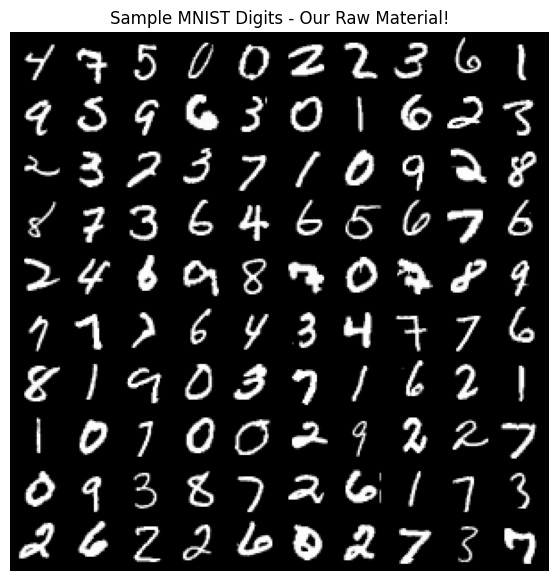

In [1]:
import random
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import tqdm as auto_tqdm # Renamed to avoid conflict if user uses both

# Load and visualize some MNIST data
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

# Get 100 random image indices
rand_indices = random.sample(range(len(mnist.data)), 100)

# Get the images
images = mnist.data[rand_indices]

print(f"Image batch shape: {images.shape}")
print(f"Individual image shape: {images[0].shape}")
print(f"Pixel value range: [{images.min()}, {images.max()}]")

# Create a nice grid to visualize
grid = torchvision.utils.make_grid(images.unsqueeze(1), nrow=10) # Add channel dimension

# Plot the grid
plt.figure(figsize=(7, 7))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')  # Permute to (H, W, C) format
plt.axis('off')
plt.title("Sample MNIST Digits - Our Raw Material!")
plt.show()


 ## Global Configuration and Hyperparameters

 Define all key hyperparameters for the models, data, and training in one place.
 This allows for easy modification and consistency across the different model versions.

In [2]:
# --- General Image & Data Parameters ---
IMG_SIZE = 28                   # Dimension of the square MNIST images (e.g., 28 for 28x28).
N_PIXELS = IMG_SIZE * IMG_SIZE  # Total number of pixels in an image.

# --- Quantization & Tokenization Settings ---
NUM_QUANTIZATION_BINS = 16  # K: Pixel vocabulary size (tokens 0 to K-1). Max 256 for 8-bit.
# The start/padding token will be an integer outside the 0 to K-1 range.
# We'll use K as its value, so token embedding layers need to accommodate K+1 distinct values.
START_TOKEN_VALUE_INT = NUM_QUANTIZATION_BINS
NUM_CLASSES = 10  # Number of classes for conditional generation (MNIST digits 0-9)

# --- Autoregressive Model Architecture ---\n",
CONTEXT_LENGTH = 28  # Number of previous tokens (context window) fed to the MLP.
HIDDEN_SIZE = 1024  # Size of hidden layers in the MLPs.
# For Model V2 & V3 (Positional Embeddings)
POS_EMBEDDING_DIM = 32  # Dimension for learnable positional embeddings (one for row, one for column).
# For Model V3 (Token Embeddings)
TOKEN_EMBEDDING_DIM = 16  # Dimension for learned pixel token embeddings.
CLASS_EMBEDDING_DIM = 16  # Dimension for learned class label embeddings (Model V3)

# --- Dataset Generation ---
MAX_SAMPLES = 5000000           # Maximum number of (context, target) training pairs to generate from MNIST.
                                # Helps keep data generation and training times manageable.

# --- Training Hyperparameters (shared across V1, V2, V3 for simplicity) ---
LEARNING_RATE = 0.001           # Learning rate for the AdamW optimizer.
EPOCHS = 20                     # Number of training epochs for each model.
BATCH_SIZE_TRAIN = 512          # Batch size used during model training.

# --- Device Setup (Attempt to use GPU if available) ---
# This device variable will be used globally by training and generation functions.
_device_type = "cpu" # Default
if torch.cuda.is_available():
    _device_type = "cuda"
    print("Global Config: CUDA (GPU) is available. Using CUDA.")
elif torch.backends.mps.is_available(): # For Apple Silicon
    _device_type = "mps"
    print("Global Config: MPS (Apple Silicon GPU) is available. Using MPS.")
else:
    print("Global Config: No GPU detected. Using CPU.")
device = torch.device(_device_type) # Define the global device variable


Global Config: CUDA (GPU) is available. Using CUDA.


 ## The "Pixel as Token" Approach: Quantizing Intensities

 We treat image generation more like language modeling. Each pixel's intensity will be *quantized* into one of a discrete number of bins. Each bin then gets an integer label, turning our pixels into "tokens" or "words" from a fixed vocabulary.

 ### 1. Quantization:

 - We take the continuous grayscale pixel values (0.0 to 1.0).
 - We divide this range into `K` discrete bins (e.g., `K=16` or `K=256`).
 - Each pixel's original intensity is mapped to the integer label of the bin it falls into.
 - Example: If `K=4`, intensities 0.0-0.25 map to token 0, 0.25-0.5 to token 1, etc.

 ### 2. Prediction as Classification:

 - The model's task is now to predict the *integer label* (token) of the next pixel, given the tokens of previous pixels.
 - This is a *K-class classification problem* for each pixel.

 *Benefits:*

 - Allows using powerful classification machinery (like Cross-Entropy loss).
 - Can be combined with techniques like embedding layers for tokens, similar to NLP.

 *Trade-offs:*

 - *Information Loss:* Quantization inherently loses some precision from the original grayscale values. More bins reduce this loss but increase model complexity.
 - *Vocabulary Size:* The number of bins (`K`) becomes our vocabulary size.

Loaded 60000 quantized training images.

Visualizing a few samples from the quantized dataset...
Shape of a single quantized image from dataset: torch.Size([1, 28, 28])
Data type: torch.int64
Unique labels in first sample: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


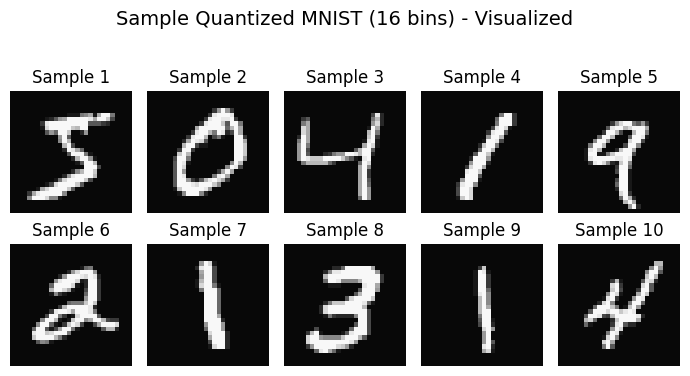

In [3]:
# --- Data Loading and Quantization ---
def quantize_tensor(tensor_image, num_bins):
    """Quantizes a tensor image (values 0-1) into num_bins integer labels (0 to num_bins-1)."""
    # Scale to [0, num_bins - epsilon] then floor to get integer labels
    # tensor_image is already in [0,1]
    scaled_image = tensor_image * (num_bins - 1e-6) # Subtract epsilon to handle 1.0 correctly
    quantized_image = torch.floor(scaled_image).long() #.long() for integer labels
    return quantized_image

# Transform pipeline
transform_quantize = transforms.Compose([
    transforms.ToTensor(), # Converts to [0,1] float tensor
    transforms.Lambda(lambda x: quantize_tensor(x, NUM_QUANTIZATION_BINS)) # Quantize to integer labels
])

# MNIST dataset
trainset_quantized = torchvision.datasets.MNIST(root='./data', train=True,
                                                 download=True, transform=transform_quantize)

print(f"Loaded {len(trainset_quantized)} quantized training images.")

# --- Visualize Quantized Data ---

# Helper to de-quantize for visualization
def dequantize_tensor(quantized_image_labels, num_bins):
    """Converts integer labels back to approximate normalized grayscale values (centers of bins)."""
    # Map label L to (L + 0.5) / num_bins
    return (quantized_image_labels.float() + 0.5) / num_bins

print("\nVisualizing a few samples from the quantized dataset...")
fig_vis, axes_vis = plt.subplots(2, 5, figsize=(7, 4))
fig_vis.suptitle(f"Sample Quantized MNIST ({NUM_QUANTIZATION_BINS} bins) - Visualized", fontsize=14)
for i, ax in enumerate(axes_vis.flat):
    quantized_single_image_int, _ = trainset_quantized[i] # Get i-th sample from Dataset
    # quantized_single_image_int shape is likely [1, IMG_SIZE, IMG_SIZE]
    
    if i == 0: # Print info for the first sample
        print(f"Shape of a single quantized image from dataset: {quantized_single_image_int.shape}")
        print(f"Data type: {quantized_single_image_int.dtype}")
        print(f"Unique labels in first sample: {torch.unique(quantized_single_image_int)}")

    vis_image_dequantized = dequantize_tensor(quantized_single_image_int.squeeze(), NUM_QUANTIZATION_BINS)
    ax.imshow(vis_image_dequantized, cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Sample {i+1}")
    ax.axis('off')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

 ## Building Our First Token Predictor: A Basic MLP

 Now that we have quantized our pixels, or *tokens*, (from 0 to NUM_QUANTIZATION_BINS-1), let's build our first autoregressive model. The goal is simple: given a token sequence of length *CONTEXT_LENGTH*, predict the next token.

 For this first version, we will try a fairly direct approach:

 1. *Representing Tokens*: Our tokens are integers from 0 to NUM_QUANTIZATION_BINS-1. To feed them into the neural network, a common approach is to use *one-hot encoding*. For example, if a token is represented as *3*, the one-hot encoding is a list of length (NUM_QUANTIZATION_BINS + 1) with a 1 at index 3 and 0s elsewhere. The *+1* is for the start token and it will have its own encoding, too. This way each token has its own unique representation.
 2. *Model Architecture*: We'll use a simple MLP to predict the next token, the input will be the one-hot encoding of the previous tokens, and the MLP will learn to map the one-hot encodings to the next token.
 3. *Output*: The MLP will output scores (logits) for each of the NUM_QUANTIZATION_BINS possible pixel tokens, telling us how likely each token is to be the next one.

 Let's implement this and see what kind of outputs we can get. Our focus here is to create a basic auto-regressive loop and see how our model can generate an image pixel-by-pixel using direct representation of the pixels.

In [4]:
class OneHotPixelPredictor(nn.Module):
    def __init__(self, num_pixel_values, context_length, hidden_size, dropout_rate=0.25):
        super(OneHotPixelPredictor, self).__init__()
        self.num_pixel_values = num_pixel_values
        self.context_length = context_length # This is the length of the context window
        self.hidden_size = hidden_size
        
        # The size of one-hot encoding is num_pixel_values + 1 (+1 for the start token)
        self.one_hot_vector_size = num_pixel_values + 1

        # The input to the MLP is the one-hot encoding of the previous tokens
        self.mlp_input_dim = context_length * (self.one_hot_vector_size)

        # The MLP has three layers, with a dropout layer in between
        self.fc1 = nn.Linear(self.mlp_input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(hidden_size, num_pixel_values)

    def forward(self, x_tokens, training=True):
        batch_size = x_tokens.shape[0]

        # Get the one-hot encoding of the previous tokens
        one_hot_encodings = F.one_hot(x_tokens, num_classes=self.one_hot_vector_size)

        # Flatten the one-hot encodings
        flattened_one_hot_encodings = one_hot_encodings.view(batch_size, -1).float()

        # Forward through the MLP
        h = F.relu(self.fc1(flattened_one_hot_encodings))
        if training:
            h = self.dropout(h)
        h = F.relu(self.fc2(h))
        if training:
            h = self.dropout(h)
        output_logits = self.fc_out(h)

        return output_logits


In [5]:
# Instantiate Model V1
model_one_hot_pixel_predictor = OneHotPixelPredictor(
    num_pixel_values=NUM_QUANTIZATION_BINS, # K
    context_length=CONTEXT_LENGTH,
    hidden_size=HIDDEN_SIZE
)

print("--- Model V1: OneHotPixelPredictor ---")
print(f"  Pixel Vocabulary Size (K for output classes): {NUM_QUANTIZATION_BINS}")
print(f"  One-Hot Vector Size (K + start_token): {model_one_hot_pixel_predictor.one_hot_vector_size}")
print(f"  Context Length: {CONTEXT_LENGTH}")
print(f"  Hidden Size: {HIDDEN_SIZE}")
print(f"  Input dimension to MLP: {CONTEXT_LENGTH * model_one_hot_pixel_predictor.one_hot_vector_size}")
print(f"  Model V1 parameters: {sum(p.numel() for p in model_one_hot_pixel_predictor.parameters()):,}")


--- Model V1: OneHotPixelPredictor ---
  Pixel Vocabulary Size (K for output classes): 16
  One-Hot Vector Size (K + start_token): 17
  Context Length: 28
  Hidden Size: 1024
  Input dimension to MLP: 476
  Model V1 parameters: 1,554,448



 ## The Heart of Autoregression: Context Windows

 Now for the fun part! How do we actually implement "predicting the next pixel based on previous pixels"?

 The key insight is *context windows*. Instead of using *all* previous pixels, we use a *sliding window* of the last `k` pixels as our context.

 *Mathematically*, instead of modeling \(P(x_i | x_1, x_2, ..., x_{i-1})\), we approximate it as:

 $$P(x_i | x_{i-1}, x_{i-2}, ..., x_{i-k})$$

 This is called a *k-th order Markov assumption* - we assume the immediate past is most informative for predicting the future.

 *But wait!* What about the first few pixels that don't have enough history? That's where our *start tokens* come in - they're like saying "this is the beginning of an image" to our model.

 ## Building Our Neural Network: Predicting Pixel Tokens

 Our neural network will now predict a *distribution over the possible pixel tokens (integer labels)* for the next pixel.

In [6]:
def create_token_training_data(quantized_dataset, context_length, start_token_int, num_pixel_values, max_samples=1000000, max_images_to_process=None, random_drop=0.8):
    """
    Create training data (context tokens, target token) for Model V1 directly from a quantized Dataset.
    
    Args:
        quantized_dataset: PyTorch Dataset object yielding quantized image tensors.
        context_length (int): Size of context window.
        start_token_int (int): Integer value for the start/padding token.
        num_pixel_values (int): The number of actual pixel values (K).
        max_samples (int): Maximum number of (context,target) training pairs to generate.
        max_images_to_process (int, optional): Limit the number of images from the dataset to process. Defaults to all.
    
    Returns:
        contexts (Tensor): [N_SAMPLES, context_length] of integer tokens.
        targets (Tensor): [N_SAMPLES] of integer target tokens (0 to K-1).
    """
    all_contexts = []
    all_targets = []
    samples_collected = 0
    
    num_images_to_process = len(quantized_dataset)
    if max_images_to_process is not None:
        num_images_to_process = min(num_images_to_process, max_images_to_process)

    print(f"Generating V1 training data from {num_images_to_process} images (max {max_samples:,} samples)...")

    # Iterate directly over the Dataset object
    pbar_images = auto_tqdm(range(num_images_to_process), desc="Processing Images for V1 Data")
    for i in pbar_images:
        if samples_collected >= max_samples:
            pbar_images.set_description(f"Max samples ({max_samples}) reached. Stopping image processing.")
            break
        
        quantized_image_tensor, _ = quantized_dataset[i] # Get i-th image (already quantized)
        # quantized_image_tensor shape is [C, H, W], e.g., [1, 28, 28]
        
        flat_token_image = quantized_image_tensor.view(-1) # Flatten to [N_PIXELS]
        n_pixels = flat_token_image.shape[0]
            
        # Padded sequence for context building
        padded_token_sequence = torch.cat([
            torch.full((context_length,), start_token_int, dtype=torch.long),
            flat_token_image # Should already be .long from quantization
        ])
            
        for pixel_idx in range(n_pixels):
            if samples_collected >= max_samples:
                break # Break inner loop
            
            if random.random() > random_drop:
                context = padded_token_sequence[pixel_idx : pixel_idx + context_length]
                target_token = flat_token_image[pixel_idx]
                    
                all_contexts.append(context)    
                all_targets.append(target_token.unsqueeze(0))
                samples_collected += 1
    
    pbar_images.close() # Close the progress bar for images

    if not all_contexts:
        print("Warning: No training samples collected. Check max_samples or dataset processing.")
        # Return empty tensors with correct number of dimensions to avoid errors later
        return torch.empty((0, context_length), dtype=torch.long), torch.empty((0), dtype=torch.long)

    contexts_tensor = torch.stack(all_contexts).long()
    targets_tensor = torch.cat(all_targets).long()
    
    indices = torch.randperm(len(contexts_tensor))
    contexts_tensor = contexts_tensor[indices]
    targets_tensor = targets_tensor[indices]
    
    print(f"Generated {len(contexts_tensor):,} V1 training pairs.")
    return contexts_tensor, targets_tensor



In [7]:


print("--- Preparing Training Data for Model V1 (OneHotPixelPredictor) ---")
# Use the new function specific to Model V1 data requirements
train_contexts, train_targets = create_token_training_data(
    trainset_quantized, # Pass the Dataset object
    CONTEXT_LENGTH, 
    START_TOKEN_VALUE_INT, 
    NUM_QUANTIZATION_BINS,
    max_samples=MAX_SAMPLES
)

print( "\nModel V1 - Data Shapes:")
print(f"  train_contexts shape: {train_contexts.shape}, dtype: {train_contexts.dtype}")
print(f"  train_targets shape: {train_targets.shape}, dtype: {train_targets.dtype}")
assert train_targets.max() < NUM_QUANTIZATION_BINS, "Target tokens for V1 exceed K-1"
assert train_targets.min() >= 0, "Target tokens for V1 are negative"


--- Preparing Training Data for Model V1 (OneHotPixelPredictor) ---
Generating V1 training data from 60000 images (max 5,000,000 samples)...


Processing Images for V1 Data:   0%|          | 0/60000 [00:00<?, ?it/s]

Generated 5,000,000 V1 training pairs.

Model V1 - Data Shapes:
  train_contexts shape: torch.Size([5000000, 28]), dtype: torch.int64
  train_targets shape: torch.Size([5000000]), dtype: torch.int64


 ### Training Our `OneHotPixelPredictor` (Model V1)

 With our `model_one_hot_pixel_predictor` (Model V1) defined and the training data (`train_contexts`, `train_targets`) prepared, we're ready to train.

 -   *Loss Function:* Since our model outputs logits for `NUM_QUANTIZATION_BINS` possible pixel token classes, and our target is a single integer class label, we'll use `CrossEntropyLoss`. This loss function is ideal for multi-class classification tasks as it combines a LogSoftmax layer and Negative Log-Likelihood Loss in one step.
 -   *Optimizer:* We'll use AdamW, a common and effective optimizer known for good performance and weight decay.

 Let's kick off the training for Model V1!

In [8]:

# --- Model V1, Data, Loss, Optimizer ---
model_one_hot_pixel_predictor.to(device)
train_contexts = train_contexts.to(device)
train_targets = train_targets.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_one_hot_pixel_predictor.parameters(), lr=LEARNING_RATE)

n_samples = len(train_contexts)
if n_samples == 0:
    print("No training samples available for Model V1. Skipping training.")
else:
    print(f"\nTraining Model V1 (OneHotPixelPredictor) on {n_samples:,} samples for {EPOCHS} epochs.")
    print(f"Predicting one of {NUM_QUANTIZATION_BINS} pixel tokens.")

    # --- Training Loop for Model V1 ---
    epoch_pbar = auto_tqdm(range(EPOCHS), desc="Model V1 Training Epochs", position=0, leave=True)
    for epoch in epoch_pbar:
        model_one_hot_pixel_predictor.train() # Set model to training mode
        epoch_loss = 0.0
        num_batches = 0
        
        # Shuffle indices for each epoch for batching from the large tensor
        indices = torch.randperm(n_samples, device=device)
        
        # Calculate total number of batches for the inner progress bar
        total_batches_in_epoch = (n_samples + BATCH_SIZE_TRAIN - 1) // BATCH_SIZE_TRAIN
        batch_pbar = auto_tqdm(range(0, n_samples, BATCH_SIZE_TRAIN), 
                             desc=f"Epoch {epoch+1}/{EPOCHS}", 
                             position=1, leave=False, 
                             total=total_batches_in_epoch)

        for start_idx in batch_pbar:
            end_idx = min(start_idx + BATCH_SIZE_TRAIN, n_samples)
            if start_idx == end_idx: continue # Skip if batch is empty

            batch_indices = indices[start_idx:end_idx]
            
            batch_context_tokens = train_contexts[batch_indices]  # Integer tokens
            batch_target_tokens = train_targets[batch_indices]    # Integer tokens (0 to K-1)
            
            optimizer.zero_grad()
            
            # Model V1 forward pass - x_tokens are integer tokens, training=True
            output_logits = model_one_hot_pixel_predictor(batch_context_tokens, training=True) 
            
            loss = criterion(output_logits, batch_target_tokens)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            
            if num_batches % 50 == 0: # Update progress bar postfix less frequently
                 batch_pbar.set_postfix(loss=f"{loss.item():.4f}")
        
        if num_batches > 0: # Avoid division by zero if n_samples was small
            avg_loss = epoch_loss / num_batches
            epoch_pbar.set_postfix(avg_loss=f"{avg_loss:.4f}")
        else:
            epoch_pbar.set_postfix(avg_loss="N/A")



Training Model V1 (OneHotPixelPredictor) on 5,000,000 samples for 20 epochs.
Predicting one of 16 pixel tokens.


Model V1 Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/9766 [00:00<?, ?it/s]

 ## Generating Images with Model V1

 After training our `OneHotPixelPredictor`, let's see what kind of images it can generate. The autoregressive generation process involves:

 1.  Initializing a context window, filled with our special `START_TOKEN_VALUE_INT`.
 2.  Feeding this current context to the trained model to obtain logits (scores) for each possible next pixel token.
 3.  Converting these logits into a probability distribution using the softmax function. We can also apply a "temperature" parameter here to control the randomness of sampling:
     *   *Temperature = 1.0:* Standard sampling according to the model's learned probabilities.
     *   *Temperature < 1.0 (e.g., 0.7):* Makes the model's choices "sharper" or more deterministic, favoring higher-probability tokens (more greedy).
     *   *Temperature > 1.0 (e.g., 1.2):* Makes the sampling more random, increasing diversity but potentially at the cost of coherence.
 4.  Sampling the next pixel token from this probability distribution.
 5.  Appending this newly sampled token to our sequence of generated pixels.
 6.  Updating the context window by shifting it (removing the oldest token) and adding the newly generated token.
 7.  Repeating steps 2-6 until all `N_PIXELS` for a full image have been generated.
 8.  Finally, de-quantizing the sequence of generated integer tokens back into visualizable grayscale values.

 Let's see how our Model V1, which uses one-hot encoded tokens and no explicit positional information, performs at this task.


--- Generating Images from Model V1 (OneHotPixelPredictor) ---


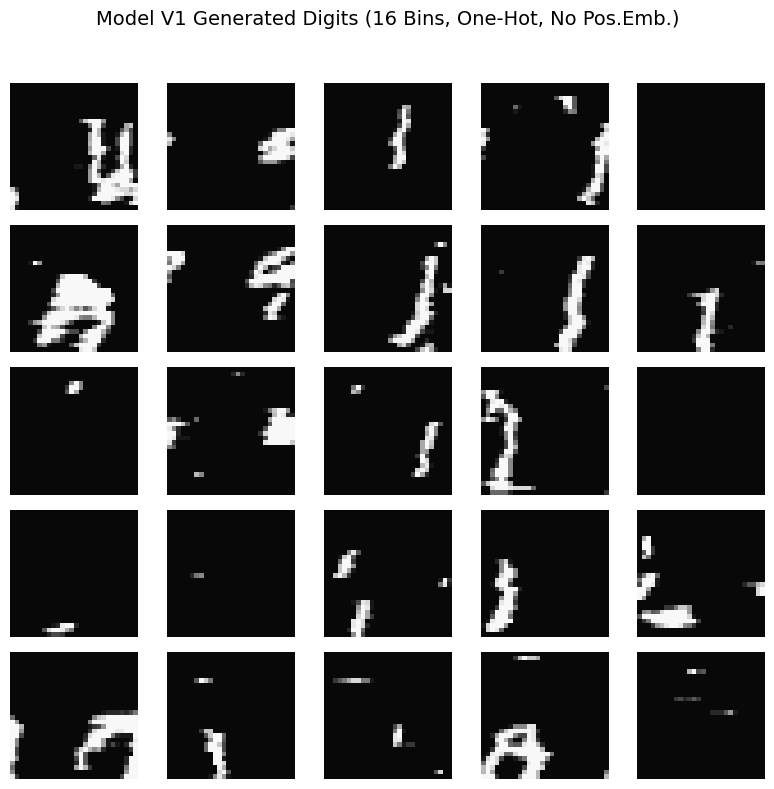

In [9]:
def generate_image_v1(model, context_length, start_token_int, num_pixel_values_k, 
                      img_size, current_device, temperature=1.0):
    """
    Generates a single image using Model V1 (OneHotPixelPredictor).
    Args:
        model: The trained OneHotPixelPredictor model.
        context_length (int): Length of the context window.
        start_token_int (int): Integer value for the start token.
        num_pixel_values_k (int): K, the number of possible actual pixel tokens (e.g., NUM_QUANTIZATION_BINS).
        img_size (int): Dimension of the square image.
        current_device (torch.device): Device to run generation on.
        temperature (float): Softmax temperature for sampling.
    Returns:
        numpy.ndarray: De-quantized grayscale image.
        list: List of generated integer pixel tokens.
    """
    model.eval() # Set model to evaluation mode
    model.to(current_device) # Ensure model is on the correct device
    
    total_pixels_to_generate = img_size * img_size
    
    # Initialize context with integer start tokens on the correct device
    current_context_tokens_tensor = torch.full((1, context_length), start_token_int, dtype=torch.long, device=current_device)
    generated_pixel_tokens_list = []
    
    # tqdm for pixel generation can be slow if generating many images one by one. 
    # Consider removing if it clutters output too much for multiple image generations.
    # For a single image generation in a blog, it's illustrative.
    pixel_gen_pbar = auto_tqdm(range(total_pixels_to_generate), desc="Generating V1 Image Pixels", leave=False, position=0, disable=True) # Disable for multi-image plot

    with torch.no_grad():
        for _ in pixel_gen_pbar:
            # Model V1 forward pass - x_tokens are integer tokens, training=False
            # Input tensor shape: [1, context_length]
            output_logits = model(current_context_tokens_tensor, training=False) # Logits: [1, NUM_QUANTIZATION_BINS]
            
            # Apply temperature and get probabilities
            probabilities = F.softmax(output_logits / temperature, dim=-1).squeeze() # Squeeze to shape [NUM_QUANTIZATION_BINS]
            
            # Sample the next pixel token
            next_pixel_token = torch.multinomial(probabilities, num_samples=1).item() # .item() gets Python number
            
            generated_pixel_tokens_list.append(next_pixel_token)
            
            # Update context: shift and append the new token
            # Keep as a tensor on the correct device
            new_token_tensor = torch.tensor([[next_pixel_token]], dtype=torch.long, device=current_device)
            current_context_tokens_tensor = torch.cat([current_context_tokens_tensor[:, 1:], new_token_tensor], dim=1)
    
    # Convert list of Python numbers to a tensor for dequantization
    generated_tokens_tensor = torch.tensor(generated_pixel_tokens_list, dtype=torch.long) # Create on CPU then move if needed by dequantize
    dequantized_image_array = dequantize_tensor(generated_tokens_tensor, num_pixel_values_k).numpy().reshape(img_size, img_size)
    
    return dequantized_image_array, generated_pixel_tokens_list

# --- Generate and Visualize Multiple Images from Model V1 ---
if n_samples > 0: # Only generate if model was trained
    print("\n--- Generating Images from Model V1 (OneHotPixelPredictor) ---")
    n_images_to_generate = 25 # Generate a 5x5 grid
    fig_gen, axes_gen = plt.subplots(5, 5, figsize=(8, 8)) # Slightly larger figure
    fig_gen.suptitle(f"Model V1 Generated Digits ({NUM_QUANTIZATION_BINS} Bins, One-Hot, No Pos.Emb.)", fontsize=14)

    for i in range(n_images_to_generate):
        row, col = i // 5, i % 5
        ax = axes_gen[row, col]
        
        dequantized_img, _ = generate_image_v1(
            model_one_hot_pixel_predictor, 
            CONTEXT_LENGTH, 
            START_TOKEN_VALUE_INT, 
            NUM_QUANTIZATION_BINS, 
            IMG_SIZE, 
            device, # Pass the globally defined device
            temperature=1.0 # You can experiment with temperature
        )
        ax.imshow(dequantized_img, cmap='gray', vmin=0, vmax=1)
        # ax.set_title(f"V1 #{i+1}", fontsize=8) # Title per image can be noisy, optional
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()
else:
    print("Skipping Model V1 image generation as no training samples were available.")


 ### Model V1: Initial Results and Observations

 Alright, let's take a look at the first batch of images generated by our `OneHotPixelPredictor` (Model V1)!

 Looking at these generated samples, here are a few key observations:

 *   *Recognizable Shapes?* Unfortunately, not really. The images don't form coherent, recognizable MNIST digits. Instead, we see patterns that are quite abstract and noisy.
 *   *Dominant Patterns: Horizontal Streaks:* A very prominent feature is the presence of horizontal streaks or bands of white (or lighter) pixels against a predominantly dark background. It seems the model has learned some very local, short-range correlations, possibly related to the raster scan order (e.g., "if the last few pixels were white, the next one is also likely white for a short stretch").
 *   *Repetitive Textures:* The generations have a somewhat repetitive, textural quality due to these streaks. There isn't much variation in the *types* of structures being formed beyond these horizontal elements.
 *   *Lack of Global Coherence:* Crucially, there's an almost complete absence of global structure. The horizontal streaks appear somewhat randomly placed across the image canvas and don't coordinate to form larger, meaningful shapes like the curves and loops of digits. The model doesn't seem to have a *plan* for the overall image.
 *   *Impact of Quantization Visible:* The blocky nature of the 16 quantization bins is apparent, which is expected.

 *Why are we seeing these kinds of results?* Two key aspects of our very basic Model V1 are likely major contributors:

 *No Positional Information:* Our current MLP processes a flat window of context tokens. It has *no explicit information* about *where* in the 2D image it is currently trying to predict a pixel. Is it at the top-left, the center, the bottom-right? Without this spatial awareness, it's incredibly hard for the model to learn to, for example, start a stroke at a particular location, curve it appropriately, and end it correctly to form part of a digit. The horizontal streaks might be a consequence of learning simple local rules that get repeated because the model doesn't know when or where to change its behavior based on image location.

 These initial results, while not producing digits, are incredibly valuable. They highlight a key limitation and clearly motivate our next step. *What if we could give our model a sense of 'location' for each pixel it predicts?* This is precisely what we'll explore by *introducing positional encodings in Model V2.* We'll keep the one-hot encoding for pixel tokens for now and see just how much impact adding spatial information can have.

## Model V2: Giving Our Predictor a Sense of Location with Positional Encodings

 Our Model V1 struggled to create coherent images, and we hypothesized that a major reason was its lack of spatial awareness – it didn't know *where* in the image it was predicting a pixel.

 For Model V2, we'll directly address this by introducing *positional encodings*. The idea is to provide the model with explicit information about the (row, column) coordinates of the pixel it's currently trying to predict.

 How will we do this?
 1.  *Learnable Positional Embeddings:* We'll create two separate embedding layers, one for row positions (0 to `IMG_SIZE-1`) and one for column positions (0 to `IMG_SIZE-1`). Each position (e.g., row 5, column 10) will be mapped to a learnable vector (its embedding).
 2.  *Concatenation:* For each prediction step, we'll determine the row and column of the target pixel. We'll fetch their respective embeddings. These two positional embedding vectors will then be concatenated with the (still one-hot encoded) context window of previous pixel tokens.
 3.  *MLP Input:* This richer, combined representation (one-hot context + row embedding + column embedding) will be fed into our MLP.

 Our pixel tokens themselves will still be one-hot encoded for now. The main change in Model V2 is adding this crucial positional signal. The hypothesis is that by knowing *where* it's operating, the model can learn location-dependent rules and generate more structured images. Let's see!

In [10]:
class OneHotPixelPredictorWithPosition(nn.Module):
    def __init__(self, num_pixel_values, context_length, hidden_size, 
                 img_size, pos_embedding_dim, dropout_rate=0.25):
        super(OneHotPixelPredictorWithPosition, self).__init__()
        self.num_pixel_values = num_pixel_values # K
        self.context_length = context_length
        self.img_size = img_size # e.g., 28 for MNIST
        self.pos_embedding_dim = pos_embedding_dim # Dimension for each positional embedding (row/col)

        # For one-hot encoding of context tokens
        self.one_hot_vector_size = num_pixel_values + 1 # K + 1 (for start token)
        one_hot_context_dim = context_length * self.one_hot_vector_size

        # Learnable absolute position embeddings
        # One embedding vector for each possible row, one for each possible column
        self.row_pos_embedding = nn.Embedding(num_embeddings=img_size, embedding_dim=pos_embedding_dim)
        self.col_pos_embedding = nn.Embedding(num_embeddings=img_size, embedding_dim=pos_embedding_dim)
        
        # Total input dimension to the MLP:
        # (one-hot context) + (row_pos_embed) + (col_pos_embed)
        self.mlp_input_dim = one_hot_context_dim + (2 * self.pos_embedding_dim)
        
        self.fc1 = nn.Linear(self.mlp_input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(hidden_size, self.num_pixel_values) # Outputs K logits

    def forward(self, x_context_tokens, pixel_positions_flat, training=True):
        """
        Args:
            x_context_tokens (Tensor): Batch of context windows. Shape: [batch_size, CONTEXT_LENGTH]. Integer tokens.
            pixel_positions_flat (Tensor): Absolute flat positions (0 to N_PIXELS-1) in the image 
                                           for each sample's target pixel. Shape: [batch_size].
            training (bool): Whether in training mode.
        """
        batch_size = x_context_tokens.shape[0]

        # 1. One-hot encode context tokens
        one_hot_context = F.one_hot(x_context_tokens, num_classes=self.one_hot_vector_size).float()
        flattened_one_hot_context = one_hot_context.view(batch_size, -1)
        
        # 2. Get positional embeddings
        # Convert flat positions to row and column indices
        rows = pixel_positions_flat // self.img_size # Integer division gives row index
        cols = pixel_positions_flat % self.img_size  # Modulo gives column index
        
        row_embeds = self.row_pos_embedding(rows) # Shape: [batch_size, pos_embedding_dim]
        col_embeds = self.col_pos_embedding(cols) # Shape: [batch_size, pos_embedding_dim]
        
        # 3. Concatenate all features
        combined_features = torch.cat([
            flattened_one_hot_context,
            row_embeds,
            col_embeds
        ], dim=1) # Concatenate along the feature dimension
        
        # 4. Forward through MLP
        h = F.relu(self.fc1(combined_features))
        if training:
            h = self.dropout(h)
        h = F.relu(self.fc2(h))
        if training:
            h = self.dropout(h)
        output_logits = self.fc_out(h) # Shape: [batch_size, NUM_QUANTIZATION_BINS]
        
        return output_logits


In [11]:

# Instantiate Model V2
model_onehot_with_pos = OneHotPixelPredictorWithPosition(
    num_pixel_values=NUM_QUANTIZATION_BINS,    # K
    context_length=CONTEXT_LENGTH,
    hidden_size=HIDDEN_SIZE,
    img_size=IMG_SIZE,
    pos_embedding_dim=POS_EMBEDDING_DIM
)

print("--- Model V2: OneHotPixelPredictorWithPosition ---")
print(f"  Pixel Vocabulary Size (K for output classes): {NUM_QUANTIZATION_BINS}")
print(f"  One-Hot Vector Size for context tokens: {model_onehot_with_pos.one_hot_vector_size}")
print(f"  Context Length: {CONTEXT_LENGTH}")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Positional Embedding Dimension (per row/col): {POS_EMBEDDING_DIM}")
print(f"  Hidden Size: {HIDDEN_SIZE}")
print(f"  Total MLP Input Dimension: {model_onehot_with_pos.mlp_input_dim}")
print(f"  Model V2 parameters: {sum(p.numel() for p in model_onehot_with_pos.parameters()):,}")



--- Model V2: OneHotPixelPredictorWithPosition ---
  Pixel Vocabulary Size (K for output classes): 16
  One-Hot Vector Size for context tokens: 17
  Context Length: 28
  Image Size: 28x28
  Positional Embedding Dimension (per row/col): 32
  Hidden Size: 1024
  Total MLP Input Dimension: 540
  Model V2 parameters: 1,621,776


 ### Preparing Training Data for Model V2 (with Positional Information)

 Our Model V2, `OneHotPixelPredictorWithPosition`, now expects not only the context window of previous tokens but also the absolute position of the pixel it is trying to predict.

 This means we need to use our data preparation function to output three things for each training sample:
 1.  The context window of integer tokens (`x_context_tokens`).
 2.  The target integer token (`target_token`).
 3.  The absolute "flat" position of the target token in the image (e.g., an integer from 0 to `N_PIXELS-1`). Our model will then internally convert this flat position into row and column indices to fetch the appropriate positional embeddings.

 Let's ensure our data generation function provides this. We'll use the version that generates context, target, and position.

In [12]:
def create_randomized_token_training_data_with_pos(quantized_dataset, context_length, start_token_int, num_pixel_values, 
                                       img_total_pixels, max_samples=100000, max_images_to_process=None, random_drop=0.8):
    """
    Create training data (context tokens, target token, target position)
    for models requiring positional information.
    """
    all_contexts = []
    all_targets = []
    all_positions = [] # To store the absolute flat position of the target pixel
    samples_collected = 0
    
    num_images_to_process = len(quantized_dataset)
    if max_images_to_process is not None:
        num_images_to_process = min(num_images_to_process, max_images_to_process)

    print(f"Generating V2 training data (contexts, targets, positions) from {num_images_to_process} images (max {max_samples:,} samples)...")

    pbar_images = auto_tqdm(range(num_images_to_process), desc="Processing Images for V2 Data")
    for i in pbar_images:
        if samples_collected >= max_samples:
            pbar_images.set_description(f"Max samples ({max_samples}) reached.")
            break
        
        quantized_image_tensor, _ = quantized_dataset[i]
        flat_token_image = quantized_image_tensor.view(-1)
        n_pixels_in_image = flat_token_image.shape[0] # Should be img_total_pixels
            
        padded_token_sequence = torch.cat([
            torch.full((context_length,), start_token_int, dtype=torch.long),
            flat_token_image
        ])
            
        for pixel_idx_in_image in range(n_pixels_in_image): # This is the absolute flat position from 0 to N_PIXELS-1
            if samples_collected >= max_samples:
                break
            
            if random.random() > random_drop:
                context = padded_token_sequence[pixel_idx_in_image : pixel_idx_in_image + context_length]
                target_token = flat_token_image[pixel_idx_in_image]
                
                all_contexts.append(context)
                all_targets.append(target_token.unsqueeze(0))
                all_positions.append(torch.tensor([pixel_idx_in_image], dtype=torch.long)) # Store flat absolute position
                samples_collected += 1
    
    pbar_images.close()

    if not all_contexts:
        print("Warning: No V2 training samples collected.")
        return torch.empty((0, context_length), dtype=torch.long), torch.empty((0), dtype=torch.long), torch.empty((0), dtype=torch.long)

    contexts_tensor = torch.stack(all_contexts).long()
    targets_tensor = torch.cat(all_targets).long()
    positions_tensor = torch.cat(all_positions).long().squeeze() # Squeeze to make it [N_SAMPLES] if it became [N_SAMPLES, 1]
    
    indices = torch.randperm(len(contexts_tensor))
    contexts_tensor = contexts_tensor[indices]
    targets_tensor = targets_tensor[indices]
    positions_tensor = positions_tensor[indices]
    
    print(f"Generated {len(contexts_tensor):,} V2 training pairs.")
    return contexts_tensor, targets_tensor, positions_tensor

# --- Prepare Data for Model V2 ---
print("\n--- Preparing Training Data for Model V2 (OneHotPixelPredictorWithPosition) ---")
train_contexts, train_targets, train_positions = create_randomized_token_training_data_with_pos(
    trainset_quantized, 
    CONTEXT_LENGTH, 
    START_TOKEN_VALUE_INT, 
    NUM_QUANTIZATION_BINS,
    N_PIXELS, # Pass total number of pixels in an image
    max_samples=MAX_SAMPLES, # Adjust as needed
)

print(f"\nModel V2 - Data Shapes:")
print(f"  train_contexts shape: {train_contexts.shape}, dtype: {train_contexts.dtype}")
print(f"  train_targets shape: {train_targets.shape}, dtype: {train_targets.dtype}")
print(f"  train_positions shape: {train_positions.shape}, dtype: {train_positions.dtype}")

if len(train_targets) > 0:
    assert train_targets.max() < NUM_QUANTIZATION_BINS, "Target tokens for V2 exceed K-1"
    assert train_targets.min() >= 0, "Target tokens for V2 are negative"
    assert train_positions.max() < N_PIXELS, "Position index out of bounds"
    assert train_positions.min() >= 0, "Position index negative"
else:
    print("Skipping assertions on empty V2 data tensors.")




--- Preparing Training Data for Model V2 (OneHotPixelPredictorWithPosition) ---
Generating V2 training data (contexts, targets, positions) from 60000 images (max 5,000,000 samples)...


Processing Images for V2 Data:   0%|          | 0/60000 [00:00<?, ?it/s]

Generated 5,000,000 V2 training pairs.

Model V2 - Data Shapes:
  train_contexts shape: torch.Size([5000000, 28]), dtype: torch.int64
  train_targets shape: torch.Size([5000000]), dtype: torch.int64
  train_positions shape: torch.Size([5000000]), dtype: torch.int64


 ### Training Model V2 (with Positional Encodings)

 Now that we have our `model_onehot_with_pos` and the corresponding training data which includes positional information for each target pixel, we can proceed with training.

 The training setup will be very similar to Model V1:
 -   *Loss Function:* `CrossEntropyLoss`, as we're still predicting one of `K` pixel tokens.
 -   *Optimizer:* AdamW.
 -   *Process:* We'll iterate for a set number of epochs, shuffling our data and processing it in mini-batches. The key difference is that during the forward pass, we will now also provide the `pixel_positions_flat` to the model.

 Let's see if providing this spatial awareness helps the model learn to generate more structured images, even with the one-hot token representation.

In [13]:

# --- Model V2, Data, Loss, Optimizer ---

model_onehot_with_pos.to(device)
train_contexts = train_contexts.to(device)
train_targets = train_targets.to(device)
train_positions = train_positions.to(device) # Ensure positions are also on device

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_onehot_with_pos.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

n_samples = len(train_contexts)
if n_samples == 0:
    print("No training samples available for Model V2. Skipping training.")
else:
    print(f"\nTraining Model V2 (OneHotPixelPredictorWithPosition) on {n_samples:,} samples for {EPOCHS} epochs.")

    # --- Training Loop for Model V2 ---
    epoch_pbar = auto_tqdm(range(EPOCHS), desc="Model V2 Training Epochs", position=0, leave=True)
    for epoch in epoch_pbar:
        model_onehot_with_pos.train() # Set model to training mode
        epoch_loss = 0.0
        num_batches = 0
        
        indices = torch.randperm(n_samples, device=device)
        
        total_batches_in_epoch = (n_samples + BATCH_SIZE_TRAIN - 1) // BATCH_SIZE_TRAIN
        batch_pbar = auto_tqdm(range(0, n_samples, BATCH_SIZE_TRAIN), 
                             desc=f"Epoch {epoch+1}/{EPOCHS}", 
                             position=1, leave=False, 
                             total=total_batches_in_epoch)

        for start_idx in batch_pbar:
            end_idx = min(start_idx + BATCH_SIZE_TRAIN, n_samples)
            if start_idx == end_idx: continue

            batch_indices = indices[start_idx:end_idx]
            
            batch_context_tokens = train_contexts[batch_indices]
            batch_target_tokens = train_targets[batch_indices]
            batch_pixel_positions = train_positions[batch_indices] # Get positions for the batch
            
            optimizer.zero_grad()
            
            # Model V2 forward pass - now includes pixel_positions_flat
            output_logits = model_onehot_with_pos(
                batch_context_tokens, 
                pixel_positions_flat=batch_pixel_positions, # Pass positions
                training=True
            ) 
            
            loss = criterion(output_logits, batch_target_tokens)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            
            if num_batches % 50 == 0:
                 batch_pbar.set_postfix(loss=f"{loss.item():.4f}")
        
        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
            epoch_pbar.set_postfix(avg_loss=f"{avg_loss:.4f}")
        else:
            epoch_pbar.set_postfix(avg_loss="N/A")

    print("\nModel V2 training completed!")




Training Model V2 (OneHotPixelPredictorWithPosition) on 5,000,000 samples for 20 epochs.


Model V2 Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/9766 [00:00<?, ?it/s]


Model V2 training completed!


 ### Generating Images with Model V2 (with Positional Encodings)

 Now that Model V2, `OneHotPixelPredictorWithPosition`, has been trained with positional information, we can generate images. The autoregressive process remains largely the same as with Model V1, but with one crucial addition:

 1.  Initialize a context window with `START_TOKEN_VALUE_INT`.
 2.  For each pixel we want to generate (from pixel 0 to `N_PIXELS-1`):
     a.  Determine the *current pixel's absolute flat position*.
     b.  Feed the current context window *and* this current pixel position to the model.
     c.  Obtain logits, apply temperature, convert to probabilities via softmax.
     d.  Sample the next pixel token.
     e.  Append the sampled token to our generated sequence.
     f.  Update the context window.
 3.  Repeat until the image is complete.
 4.  De-quantize the generated tokens.

 Let's see if the added spatial awareness from positional encodings helps Model V2 produce more structured or recognizable images compared to Model V1.


--- Generating Images from Model V2 (OneHot with Position) ---


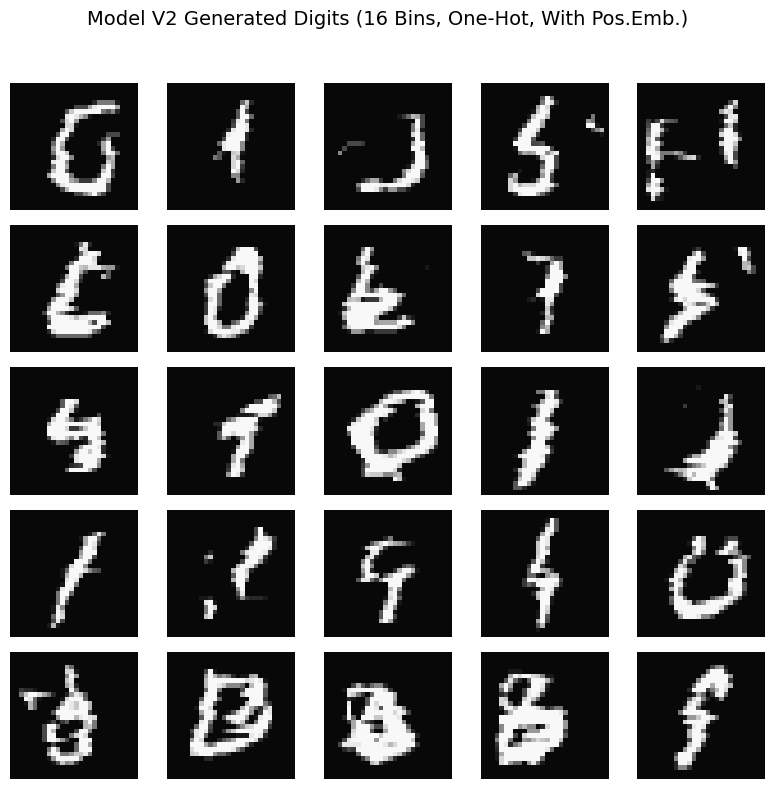

In [14]:
def generate_image_v2(model, context_length, start_token_int, num_pixel_values_k, 
                      img_size, total_num_pixels, current_device, temperature=1.0):
    """
    Generates a single image using Model V2 (OneHotPixelPredictorWithPosition).
    Args:
        model: The trained OneHotPixelPredictorWithPosition model.
        context_length (int): Length of the context window.
        start_token_int (int): Integer value for the start token.
        num_pixel_values_k (int): K, the number of possible actual pixel tokens.
        img_size (int): Dimension of the square image.
        total_num_pixels (int): Total pixels in the image (img_size * img_size).
        current_device (torch.device): Device to run generation on.
        temperature (float): Softmax temperature for sampling.
    Returns:
        numpy.ndarray: De-quantized grayscale image.
    """
    model.eval()
    model.to(current_device)
    
    current_context_tokens_tensor = torch.full((1, context_length), start_token_int, dtype=torch.long, device=current_device)
    generated_pixel_tokens_list = []
    
    pixel_gen_pbar = auto_tqdm(range(total_num_pixels), desc="Generating V2 Image Pixels", leave=False, position=0, disable=True) # Disable for multi-image plot

    with torch.no_grad():
        for i in pixel_gen_pbar: # i is the current_flat_pixel_position (0 to N_PIXELS-1)
            current_flat_pixel_position_tensor = torch.tensor([i], dtype=torch.long, device=current_device) # Shape [1]
            
            output_logits = model(
                current_context_tokens_tensor, 
                pixel_positions_flat=current_flat_pixel_position_tensor, # Pass current position
                training=False
            )
            
            probabilities = F.softmax(output_logits / temperature, dim=-1).squeeze()
            next_pixel_token = torch.multinomial(probabilities, num_samples=1).item()
            generated_pixel_tokens_list.append(next_pixel_token)
            
            new_token_tensor = torch.tensor([[next_pixel_token]], dtype=torch.long, device=current_device)
            current_context_tokens_tensor = torch.cat([current_context_tokens_tensor[:, 1:], new_token_tensor], dim=1)
    
    generated_tokens_tensor = torch.tensor(generated_pixel_tokens_list, dtype=torch.long)
    dequantized_image_array = dequantize_tensor(generated_tokens_tensor, num_pixel_values_k).numpy().reshape(img_size, img_size)
    
    return dequantized_image_array

# --- Generate and Visualize Multiple Images from Model V2 ---
if n_samples > 0: # Only generate if Model V2 was trained
    print("\n--- Generating Images from Model V2 (OneHot with Position) ---")
    n_images_to_generate = 25 # 5x5 grid
    fig_gen, axes_gen = plt.subplots(5, 5, figsize=(8, 8))
    fig_gen.suptitle(f"Model V2 Generated Digits ({NUM_QUANTIZATION_BINS} Bins, One-Hot, With Pos.Emb.)", fontsize=14)

    for i in range(n_images_to_generate):
        row, col = i // 5, i % 5
        ax = axes_gen[row, col]
        
        dequantized_img = generate_image_v2(
            model_onehot_with_pos, 
            CONTEXT_LENGTH, 
            START_TOKEN_VALUE_INT, 
            NUM_QUANTIZATION_BINS, 
            IMG_SIZE,
            N_PIXELS, # Pass N_PIXELS
            device, 
            temperature=1.0 
        )
        ax.imshow(dequantized_img, cmap='gray', vmin=0, vmax=1)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("Skipping Model V2 image generation as no training samples were available.")


### Model V2: Results with Positional Encodings

Now, let's examine the images generated by Model V2 (`OneHotPixelPredictorWithPosition`), which incorporated positional encodings while still using one-hot representations for the pixel tokens.

Comparing these to the outputs from Model V1 (which had no positional information), we can make some significant observations:

*   *Improved Structure - Emergence of Verticality:* This is the most striking difference! The dominant horizontal streaks from Model V1 are largely gone. Instead, we see a clear tendency towards *vertical structures* or alignments. The model now seems to understand that pixels "above" and "below" each other are related in a way that pixels far apart horizontally might not be (or at least, it's learned to generate patterns consistent with the vertical strokes common in digits).
*   *Hints of Digit-like Forms (but still abstract):* While still not producing clear, recognizable digits, some of these vertical structures have a more "digit-like" feel than the random noise of Model V1. You can almost squint and see hints of '1's, or parts of '7's, '4's, or other vertical segments. There's a sense that the model is *trying* to place "ink" in a more constrained, column-oriented fashion.
*   *Centering Tendency:* Many of the generated patterns appear somewhat centered within the 28x28 canvas, which is typical for MNIST digits. This suggests the positional encodings are helping the model learn *where* to place "active" pixels.
*   *Still "Noisy" and "Fragmented":* Despite the move towards verticality, the generations are still quite noisy and fragmented. The "strokes" are often broken, and there's a lack of smooth curves or connected components that would form complete digits.
*   *Coarseness from One-Hot Encoding Persists:* The blocky appearance due to the 16 quantization bins and the one-hot encoding of tokens is still evident. The model isn't (and can't easily with this representation) learning smooth transitions between pixel intensities.

*The Impact of Positional Information:*

Adding positional encoding has clearly made a substantial difference. By knowing the (row, column) coordinate of the pixel it's predicting, Model V2 has been able to:
1.  Move away from the undirected, horizontal streak patterns of Model V1.
2.  Learn to generate patterns with a strong vertical bias, which is a key characteristic of many handwritten digits.
3.  Roughly position these patterns within the typical area of a digit on the canvas.

This demonstrates the critical importance of spatial awareness for image generation tasks. Even a simple MLP, when given location information, can start to learn rudimentary structural properties.

*However, we're not quite there yet.* The generated images still lack clarity and fine detail. A remaining bottleneck is likely our *one-hot encoding of pixel tokens*. This representation treats each of our 16 pixel intensity levels as a completely distinct, unrelated category. The model has no inherent understanding that, for example, token `3` (a dark gray) is semantically "closer" to token `4` (a slightly different dark gray) than it is to token `15` (a very light gray). It must learn these relationships purely from co-occurrence, which can be inefficient and limit its ability to model subtle intensity variations.

This naturally leads us to our next and final refinement for this MLP-based autoregressive model: *What if we replace the one-hot encoding of pixel tokens with learned, dense vector representations (embeddings)?* This naturally leads us to our next refinement: What if we replace the one-hot encoding of pixel tokens with learned, dense vector representations (embeddings)? Furthermore, instead of just generating any digit, can we guide the model to generate a specific digit? This is what we'll explore in Model V3. We will combine the benefits of learned token embeddings and positional encodings, and crucially, we will introduce conditional generation by providing the model with the desired class label (i.e., the digit we want it to generate)


 ## Model V3: Enhancing Token Understanding with Learned Embeddings

 Our journey so far has shown progress. Model V1, with no spatial awareness, produced noisy streaks. Model V2, by incorporating positional encodings, started to generate more structured, vertically-oriented patterns, hinting at digit-like forms. However, the results are still far from clear MNIST digits, and a key limitation we identified was the one-hot encoding of pixel tokens. This representation forces the model to learn the relationships between different pixel intensities (e.g., that "dark gray" is similar to "slightly darker gray") from scratch, without any inherent notion of their similarity.

 For Model V3, we'll address this by introducing *learned token embeddings* for our pixel intensity values. This is a technique widely used in Natural Language Processing (NLP) with great success.

 *How it Works:*
 1.  *Embedding Layer (`nn.Embedding`):* Instead of one-hot encoding, each integer pixel token (from 0 to `NUM_QUANTIZATION_BINS-1`) and our special `START_TOKEN_VALUE_INT` will be mapped to a dense, lower-dimensional vector. These vectors are *learnable parameters* of the model.
 2.  *Learning Relationships:* During training, the model will adjust these embedding vectors. If certain pixel intensities often appear in similar contexts or lead to similar predictions, their embedding vectors will tend to become similar. This allows the model to capture the semantic "closeness" of different pixel values.
 3.  *Combined with Positional Encoding:* We will retain the absolute positional encodings from Model V2. The input to our MLP will now be a concatenation of:
     *   The learned embedding vectors for each token in the context window.
     *   The learned positional embedding for the target pixel's row.
     *   The learned positional embedding for the target pixel's column.

 By providing the model with both a richer, learned representation for pixel intensities *and* spatial awareness, we hope to see a significant improvement in the quality and coherence of the generated images. This Model V3 represents our most sophisticated MLP-based autoregressive generator in this tutorial.

In [15]:
class CategoricalPixelPredictor(nn.Module):
    def __init__(
        self,
        num_pixel_values,
        token_embedding_dim,
        context_length,
        hidden_size,
        img_size,
        pos_embedding_dim,
        start_token_integer_value,
        num_classes,
        class_embedding_dim,
        dropout_rate=0.25,
    ):  # Added num_classes, class_embedding_dim
        """
        Args:
            num_pixel_values (int): K, number of actual pixel intensity tokens (0 to K-1).
            token_embedding_dim (int): Dimension for the learned pixel token embeddings.
            context_length (int): Number of previous tokens to consider.
            hidden_size (int): Size of the hidden layers.
            img_size (int): Size of the image (assumed square).
            pos_embedding_dim (int): Dimension for learnable positional embeddings (row/col).
            start_token_integer_value (int): The integer value used for the start token.
            num_classes (int): Number of classes for conditional generation.
            class_embedding_dim (int): Dimension for learned class label embeddings.
            dropout_rate (float): Dropout rate.
        """
        super(CategoricalPixelPredictor, self).__init__()
        self.num_pixel_values = num_pixel_values  # K
        self.token_embedding_dim = token_embedding_dim
        self.context_length = context_length
        self.img_size = img_size
        self.pos_embedding_dim = pos_embedding_dim
        self.class_embedding_dim = class_embedding_dim

        self.token_vocab_size = max(num_pixel_values - 1, start_token_integer_value) + 1

        self.token_embedding = nn.Embedding(
            num_embeddings=self.token_vocab_size, embedding_dim=token_embedding_dim
        )

        self.row_pos_embedding = nn.Embedding(
            num_embeddings=img_size, embedding_dim=pos_embedding_dim
        )
        self.col_pos_embedding = nn.Embedding(
            num_embeddings=img_size, embedding_dim=pos_embedding_dim
        )

        # Class label embedding
        self.class_embedding = nn.Embedding(
            num_embeddings=num_classes, embedding_dim=class_embedding_dim
        )

        context_features_dim = context_length * token_embedding_dim
        positional_features_dim = 2 * pos_embedding_dim
        class_features_dim = class_embedding_dim  # Add class embedding dimension

        self.mlp_input_dim = (
            context_features_dim + positional_features_dim + class_features_dim
        )

        self.fc1 = nn.Linear(self.mlp_input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(hidden_size, self.num_pixel_values)

    def forward(self, x_context_tokens, pixel_positions_flat, class_labels, training=True): # Added class_labels
        """
        Args:
            x_context_tokens (Tensor): Batch of context windows. Shape: [batch_size, CONTEXT_LENGTH].
            pixel_positions_flat (Tensor): Absolute flat positions. Shape: [batch_size].
            class_labels (Tensor): Class labels for each sample. Shape: [batch_size].
            training (bool): Whether in training mode.
        """
        batch_size = x_context_tokens.shape[0]
        
        embedded_context = self.token_embedding(x_context_tokens)
        flattened_embedded_context = embedded_context.view(batch_size, -1)
        
        rows = pixel_positions_flat // self.img_size
        cols = pixel_positions_flat % self.img_size
        row_embeds = self.row_pos_embedding(rows)
        col_embeds = self.col_pos_embedding(cols)
        
        # Get class embeddings
        class_embeds = self.class_embedding(class_labels) # Shape: [batch_size, class_embedding_dim]
        
        combined_features = torch.cat([
            flattened_embedded_context,
            row_embeds,
            col_embeds,
            class_embeds # Concatenate class embeddings
        ], dim=1)
        
        h = F.relu(self.fc1(combined_features))
        if training:
            h = self.dropout(h)
        h = F.relu(self.fc2(h))
        if training:
            h = self.dropout(h)
        output_logits = self.fc_out(h)
        
        return output_logits

In [16]:
# Instantiate Model V3
model_cat_predictor = CategoricalPixelPredictor(
    num_pixel_values=NUM_QUANTIZATION_BINS,
    token_embedding_dim=TOKEN_EMBEDDING_DIM,
    context_length=CONTEXT_LENGTH,
    hidden_size=HIDDEN_SIZE,
    img_size=IMG_SIZE,
    pos_embedding_dim=POS_EMBEDDING_DIM,
    start_token_integer_value=START_TOKEN_VALUE_INT,
    num_classes=NUM_CLASSES,  # New
    class_embedding_dim=CLASS_EMBEDDING_DIM,  # New
)

print(
    "--- Model V3: CategoricalPixelPredictor (Token Embeddings + Positional Embeddings + Class Conditional) ---"
)  # Updated title
print(f"  Number of actual pixel intensity tokens (K): {NUM_QUANTIZATION_BINS}")
print(
    f"  Token Embedding Vocabulary Size (max_token_val + 1): {model_cat_predictor.token_vocab_size}"
)
print(f"  Token Embedding Dimension: {TOKEN_EMBEDDING_DIM}")
print(f"  Positional Embedding Dimension (per row/col): {POS_EMBEDDING_DIM}")
print(f"  Class Embedding Dimension: {CLASS_EMBEDDING_DIM}")  # New
print(f"  Context Length: {CONTEXT_LENGTH}")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Hidden Size: {HIDDEN_SIZE}")
print(
    f"  Total MLP Input Dimension: {model_cat_predictor.mlp_input_dim}"
)  # Will be larger now
print(
    f"  Model V3 parameters: {sum(p.numel() for p in model_cat_predictor.parameters()):,}"
)


--- Model V3: CategoricalPixelPredictor (Token Embeddings + Positional Embeddings + Class Conditional) ---
  Number of actual pixel intensity tokens (K): 16
  Token Embedding Vocabulary Size (max_token_val + 1): 17
  Token Embedding Dimension: 16
  Positional Embedding Dimension (per row/col): 32
  Class Embedding Dimension: 16
  Context Length: 28
  Image Size: 28x28
  Hidden Size: 1024
  Total MLP Input Dimension: 528
  Model V3 parameters: 1,609,920


In [17]:
def create_training_data_v3(
    quantized_dataset,
    context_length,
    start_token_int,
    img_total_pixels,
    max_samples=100000,
    max_images_to_process=None,
    random_drop=0.8
):
    """
    Create training data (context tokens, target token, target position, class label)
    for Model V3 (CategoricalPixelPredictor).
    """
    all_contexts = []
    all_targets = []
    all_positions = []
    all_labels = []  # To store class labels
    samples_collected = 0

    num_images_to_process = len(quantized_dataset)
    if max_images_to_process is not None:
        num_images_to_process = min(num_images_to_process, max_images_to_process)

    print(
        f"Generating V3 training data (contexts, targets, positions, labels) from {num_images_to_process} images (max {max_samples:,} samples)..."
    )

    pbar_images = auto_tqdm(
        range(num_images_to_process), desc="Processing Images for V3 Data"
    )
    for i in pbar_images:
        if samples_collected >= max_samples:
            pbar_images.set_description(f"Max samples ({max_samples}) reached.")
            break

        quantized_image_tensor, class_label = quantized_dataset[
            i
        ]  # Get image and label
        flat_token_image = quantized_image_tensor.view(-1)
        n_pixels_in_image = flat_token_image.shape[0]

        padded_token_sequence = torch.cat(
            [
                torch.full((context_length,), start_token_int, dtype=torch.long),
                flat_token_image,
            ]
        )

        for pixel_idx_in_image in range(n_pixels_in_image):
            if samples_collected >= max_samples:
                break

            if random.random() > random_drop:
                context = padded_token_sequence[
                    pixel_idx_in_image : pixel_idx_in_image + context_length
                ]
                target_token = flat_token_image[pixel_idx_in_image]

                all_contexts.append(context)
                all_targets.append(target_token.unsqueeze(0))
                all_positions.append(torch.tensor([pixel_idx_in_image], dtype=torch.long))
                all_labels.append(
                    torch.tensor([class_label], dtype=torch.long)
                )  # Store class label
                samples_collected += 1

    pbar_images.close()

    if not all_contexts:
        print("Warning: No V3 training samples collected.")
        return (
            torch.empty((0, context_length), dtype=torch.long),
            torch.empty((0), dtype=torch.long),
            torch.empty((0), dtype=torch.long),
            torch.empty((0), dtype=torch.long),
        )

    contexts_tensor = torch.stack(all_contexts).long()
    targets_tensor = torch.cat(all_targets).long()
    positions_tensor = torch.cat(all_positions).long().squeeze()
    labels_tensor = torch.cat(all_labels).long().squeeze()  # Store labels

    indices = torch.randperm(len(contexts_tensor))
    contexts_tensor = contexts_tensor[indices]
    targets_tensor = targets_tensor[indices]
    positions_tensor = positions_tensor[indices]
    labels_tensor = labels_tensor[indices]  # Shuffle labels accordingly

    print(f"Generated {len(contexts_tensor):,} V3 training pairs.")
    return contexts_tensor, targets_tensor, positions_tensor, labels_tensor


### Preparing Training Data for Model V3 (with Class Labels)

Our Model V3, CategoricalPixelPredictor, is designed for conditional generation. 

This means it now expects not only the context window and the target pixel's position but also the class label of the image from which the sample is drawn.
We'll adapt our data preparation to include these class labels:
1. Context Windows (train_contexts_v3): Sequences of integer tokens.
2. Target Tokens (train_targets_v3): The integer token of the actual next pixel.
3. Target Pixel Positions (train_positions_v3): The absolute flat position of the target pixel.
4. Class Labels (train_labels_v3): The integer label (0-9 for MNIST) of the image corresponding to the current training sample. The model will use an embedding of this label as part of its input."

In [18]:
print("--- Preparing Training Data for Model V3 (CategoricalPixelPredictor) ---")
train_contexts_v3, train_targets_v3, train_positions_v3, train_labels_v3 = (
    create_training_data_v3(
        trainset_quantized,
        CONTEXT_LENGTH,
        START_TOKEN_VALUE_INT,
        N_PIXELS,
        max_samples=MAX_SAMPLES,
    )
)

print("\nModel V3 - Data Shapes:")
print(
    f"  train_contexts_v3 shape: {train_contexts_v3.shape}, dtype: {train_contexts_v3.dtype}"
)
print(
    f"  train_targets_v3 shape: {train_targets_v3.shape}, dtype: {train_targets_v3.dtype}"
)
print(
    f"  train_positions_v3 shape: {train_positions_v3.shape}, dtype: {train_positions_v3.dtype}"
)
print(
    f"  train_labels_v3 shape: {train_labels_v3.shape}, dtype: {train_labels_v3.dtype}"
)  # New

if len(train_targets_v3) > 0:
    assert train_targets_v3.max() < NUM_QUANTIZATION_BINS, (
        "Target tokens for V3 exceed K-1"
    )
    assert train_targets_v3.min() >= 0, "Target tokens for V3 are negative"
    assert train_positions_v3.max() < N_PIXELS, "Position index out of bounds for V3"
    assert train_positions_v3.min() >= 0, "Position index negative for V3"
    assert train_labels_v3.max() < NUM_CLASSES, "Class label out of bounds for V3"
    assert train_labels_v3.min() >= 0, "Class label negative for V3"
else:
    print("Skipping assertions on empty V3 data tensors.")


--- Preparing Training Data for Model V3 (CategoricalPixelPredictor) ---
Generating V3 training data (contexts, targets, positions, labels) from 60000 images (max 5,000,000 samples)...


Processing Images for V3 Data:   0%|          | 0/60000 [00:00<?, ?it/s]

Generated 5,000,000 V3 training pairs.

Model V3 - Data Shapes:
  train_contexts_v3 shape: torch.Size([5000000, 28]), dtype: torch.int64
  train_targets_v3 shape: torch.Size([5000000]), dtype: torch.int64
  train_positions_v3 shape: torch.Size([5000000]), dtype: torch.int64
  train_labels_v3 shape: torch.Size([5000000]), dtype: torch.int64


 ### Training Model V3 (with Token Embeddings and Positional Encodings)

 We're now ready to train our latest MLP-based model for this tutorial, `model_cat_predictor`. This model combines:
 -   Learned dense embeddings for the pixel intensity tokens (and the start token) in the context window.
 -   Learned positional embeddings for the row and column of the target pixel.

 The training setup (loss function, optimizer) will be the same as for Model V2. We expect that the richer input representation (learned token embeddings for context, positional embeddings for location, and class embeddings for the desired digit) will allow the model to learn more effectively and generate images conditioned on the provided class label.

In [19]:
# --- Model V3, Data, Loss, Optimizer ---
model_cat_predictor.to(device)  # Ensure model is on device

# Use the V3 specific data
train_contexts_v3_dev = train_contexts_v3.to(device)
train_targets_v3_dev = train_targets_v3.to(device)
train_positions_v3_dev = train_positions_v3.to(device)
train_labels_v3_dev = train_labels_v3.to(device)  # Labels to device

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model_cat_predictor.parameters(), lr=LEARNING_RATE, weight_decay=1e-5
)

n_samples_v3 = len(train_contexts_v3)
if n_samples_v3 == 0:
    print("No training samples available for Model V3. Skipping training.")
else:
    print(
        f"\nTraining Model V3 (CategoricalPixelPredictor) on {n_samples_v3:,} samples for {EPOCHS} epochs."
    )

    epoch_pbar = auto_tqdm(
        range(EPOCHS), desc="Model V3 Training Epochs", position=0, leave=True
    )
    for epoch in epoch_pbar:
        model_cat_predictor.train()
        epoch_loss = 0.0
        num_batches = 0

        indices = torch.randperm(n_samples_v3, device=device)

        total_batches_in_epoch = (
            n_samples_v3 + BATCH_SIZE_TRAIN - 1
        ) // BATCH_SIZE_TRAIN
        batch_pbar = auto_tqdm(
            range(0, n_samples_v3, BATCH_SIZE_TRAIN),
            desc=f"Epoch {epoch + 1}/{EPOCHS}",
            position=1,
            leave=False,
            total=total_batches_in_epoch,
        )

        for start_idx in batch_pbar:
            end_idx = min(start_idx + BATCH_SIZE_TRAIN, n_samples_v3)
            if start_idx == end_idx:
                continue

            batch_indices = indices[start_idx:end_idx]

            batch_context_tokens = train_contexts_v3_dev[batch_indices]
            batch_target_tokens = train_targets_v3_dev[batch_indices]
            batch_pixel_positions = train_positions_v3_dev[batch_indices]
            batch_class_labels = train_labels_v3_dev[
                batch_indices
            ]  # Get class labels for batch

            optimizer.zero_grad()

            output_logits = model_cat_predictor(
                batch_context_tokens,
                pixel_positions_flat=batch_pixel_positions,
                class_labels=batch_class_labels,  # Pass class labels
                training=True,
            )

            loss = criterion(output_logits, batch_target_tokens)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            if num_batches % 50 == 0:
                batch_pbar.set_postfix(loss=f"{loss.item():.4f}")

        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
            epoch_pbar.set_postfix(avg_loss=f"{avg_loss:.4f}")
        else:
            epoch_pbar.set_postfix(avg_loss="N/A")

    print("\nModel V3 training completed!")



Training Model V3 (CategoricalPixelPredictor) on 5,000,000 samples for 20 epochs.


Model V3 Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 2/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 3/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 4/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 5/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 6/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 7/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 8/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 9/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 10/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 11/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 12/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 13/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 14/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 15/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 16/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 17/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 18/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 19/20:   0%|          | 0/9766 [00:00<?, ?it/s]

Epoch 20/20:   0%|          | 0/9766 [00:00<?, ?it/s]


Model V3 training completed!


### Generating Images with Model V3 (Token Embeddings + Positional Encodings)

With our `CategoricalPixelPredictor` (Model V3) trained, it's time for the moment of truth! This model uses learned embeddings for pixel intensity tokens and positional encodings, representing our most sophisticated MLP-based model in this tutorial, now capable of conditional image generation.

 The generation process will be similar to Model V2, but with a key difference: we will now provide a target class label (e.g., "generate a 7") to the model at each step. The model will use an embedding of this class label, along with the context and current pixel position, to predict the next pixel token.
1. Initialize a context window with START_TOKEN_VALUE_INT.
2. Provide the desired class_label for the image to be generated.
3. For each pixel i (from 0 to N_PIXELS-1):
 a. Feed the current context window, the current pixel's position (i), and the target class_label to the model.
 b. Obtain logits, apply temperature, sample the next pixel token.
 c. Update context and append the token to the generated sequence.
4. Repeat until the image is complete.
5. De-quantize.

We are eager to see if the model can now generate specific digits when prompted, leveraging learned token embeddings, positional encodings, and class conditioning.

In [20]:
def generate_image_v3_conditional_with_analysis(
    model,
    context_length,
    start_token_int,
    num_pixel_values,
    class_label,  # New: class label for conditioning
    img_size=28,
    device="cpu",
    temperature=1.0,
):
    """Generates a single image conditionally, tracks chosen tokens, and their probabilities."""
    model.eval()
    model.to(device)

    current_context_tokens = torch.full(
        (1, context_length), start_token_int, dtype=torch.long, device=device
    )
    # Prepare class label tensor (needs to be batch_size=1 for single image generation)
    class_label_tensor = torch.tensor([class_label], dtype=torch.long, device=device)

    generated_tokens_list = []
    chosen_token_probs_list = []
    entropy_list = []

    total_pixels = img_size * img_size

    with torch.no_grad():
        for i in range(total_pixels):
            current_pixel_position = torch.tensor([i], dtype=torch.long, device=device)

            # Pass class_label_tensor to the model
            output_logits = model(
                current_context_tokens,
                pixel_positions_flat=current_pixel_position,
                class_labels=class_label_tensor,  # Pass class label
                training=False,
            )  # Ensure training is False

            probabilities = F.softmax(output_logits / temperature, dim=-1).squeeze()

            next_token = torch.multinomial(probabilities, 1).item()
            generated_tokens_list.append(next_token)
            chosen_token_probs_list.append(probabilities[next_token].item())

            current_entropy = -torch.sum(
                probabilities * torch.log(probabilities + 1e-9)
            ).item()
            entropy_list.append(current_entropy)

            new_token_tensor = torch.tensor(
                [[next_token]], dtype=torch.long, device=device
            )
            current_context_tokens = torch.cat(
                [current_context_tokens[:, 1:], new_token_tensor], dim=1
            )

    img_tokens_tensor = torch.tensor(generated_tokens_list, dtype=torch.long)
    dequantized_img_arr = (
        dequantize_tensor(img_tokens_tensor, num_pixel_values)
        .numpy()
        .reshape(img_size, img_size)
    )

    chosen_token_probs_arr = np.array(chosen_token_probs_list).reshape(
        img_size, img_size
    )
    entropy_arr = np.array(entropy_list).reshape(img_size, img_size)

    return dequantized_img_arr, chosen_token_probs_arr, entropy_arr



--- Generating Images from Model V3 (Token Embeddings + Position + Class Conditional) ---


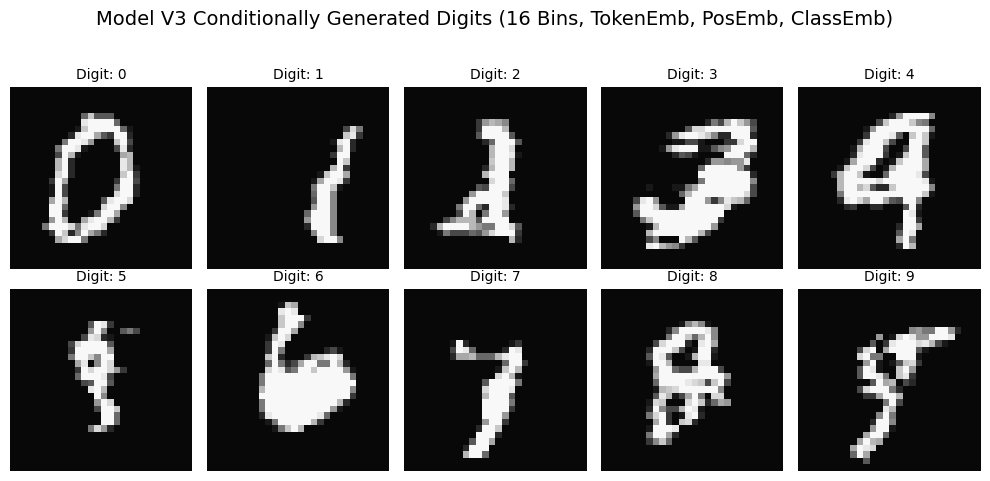

\n--- Analyzing Generation for Digit 7 (Model V3) ---


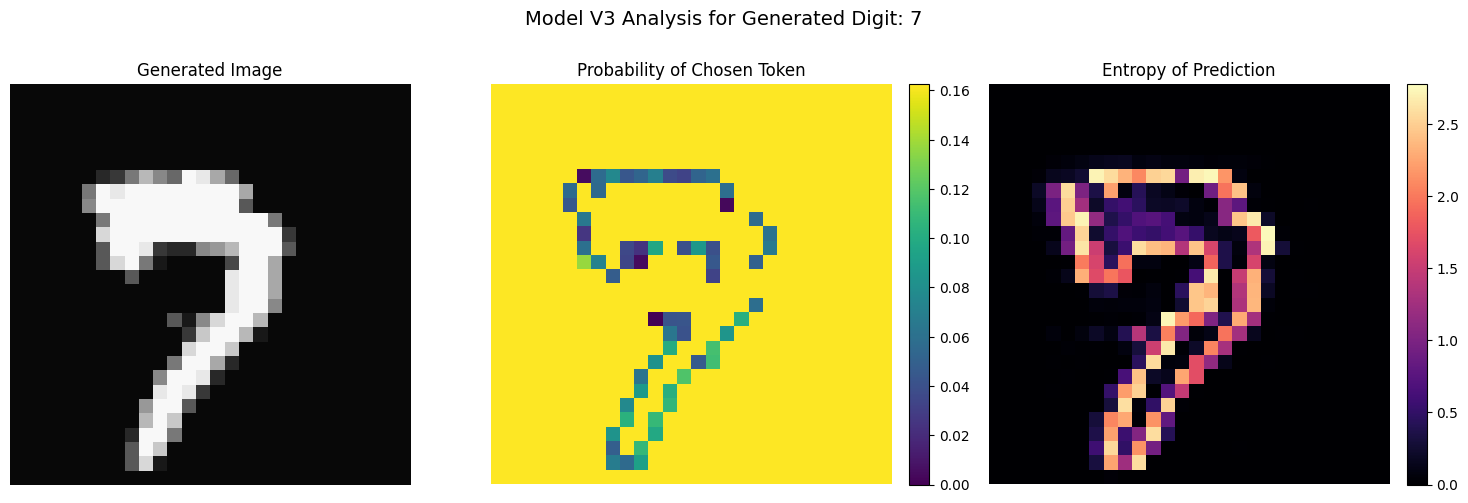

In [24]:
# --- Generate and Visualize Multiple Images from Model V3 ---
if n_samples_v3 > 0:  # Only generate if Model V3 was trained
    print(
        "\n--- Generating Images from Model V3 (Token Embeddings + Position + Class Conditional) ---"
    )

    # Generate one image for each class (0-9 if NUM_CLASSES is 10)
    # Adjust n_rows, n_cols if NUM_CLASSES is different
    n_rows = 2
    n_cols = 5
    n_images_to_generate = n_rows * n_cols

    fig_gen, axes_gen = plt.subplots(n_rows, n_cols, figsize=(10, 5))  # Adjust figsize
    fig_gen.suptitle(
        f"Model V3 Conditionally Generated Digits ({NUM_QUANTIZATION_BINS} Bins, TokenEmb, PosEmb, ClassEmb)",
        fontsize=14,
    )

    for i in range(n_images_to_generate):
        if i >= NUM_CLASSES:  # Don't try to generate for classes that don't exist
            if axes_gen.ndim > 1:
                axes_gen.flat[i].axis("off")  # Turn off axis if no image
            else:  # if only one row
                axes_gen[i].axis("off")
            continue

        class_to_generate = i  # Generate digit 'i'

        ax = axes_gen.flat[i]

        # Using the modified generation function
        dequantized_img, _, _ = generate_image_v3_conditional_with_analysis(
            model_cat_predictor,
            CONTEXT_LENGTH,
            START_TOKEN_VALUE_INT,
            NUM_QUANTIZATION_BINS,
            class_label=class_to_generate,  # Pass the class label
            img_size=IMG_SIZE,
            device=device,
            temperature=1.0,
        )
        ax.imshow(dequantized_img, cmap="gray", vmin=0, vmax=1)
        ax.set_title(f"Digit: {class_to_generate}", fontsize=10)
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
else:
    print("Skipping Model V3 image generation as no training samples were available.")

# --- Optional: Generate and visualize probabilities/entropy for a single digit ---
if n_samples_v3 > 0:
    chosen_digit_to_analyze = 7  # Example: Analyze digit 7
    print(
        f"\\n--- Analyzing Generation for Digit {chosen_digit_to_analyze} (Model V3) ---"
    )

    img_arr, probs_arr, entropy_arr = generate_image_v3_conditional_with_analysis(
        model_cat_predictor,
        CONTEXT_LENGTH,
        START_TOKEN_VALUE_INT,
        NUM_QUANTIZATION_BINS,
        class_label=chosen_digit_to_analyze,
        img_size=IMG_SIZE,
        device=device,
        temperature=1.0,
    )

    fig_analysis, axs_analysis = plt.subplots(1, 3, figsize=(15, 5))
    fig_analysis.suptitle(
        f"Model V3 Analysis for Generated Digit: {chosen_digit_to_analyze}", fontsize=14
    )

    axs_analysis[0].imshow(img_arr, cmap="gray", vmin=0, vmax=1)
    axs_analysis[0].set_title("Generated Image")
    axs_analysis[0].axis("off")

    im1 = axs_analysis[1].imshow(
        probs_arr, cmap="viridis", vmin=0, vmax=1.0 / NUM_QUANTIZATION_BINS + 0.1
    )  # Adjust vmax
    axs_analysis[1].set_title("Probability of Chosen Token")
    axs_analysis[1].axis("off")
    fig_analysis.colorbar(im1, ax=axs_analysis[1], fraction=0.046, pad=0.04)

    max_entropy = np.log(NUM_QUANTIZATION_BINS)  # Max possible entropy for K classes
    im2 = axs_analysis[2].imshow(entropy_arr, cmap="magma", vmin=0, vmax=max_entropy)
    axs_analysis[2].set_title("Entropy of Prediction")
    axs_analysis[2].axis("off")
    fig_analysis.colorbar(im2, ax=axs_analysis[2], fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
